# CNN Waste Classification 1: Wrangling & EDA

This notebook details the foundational phase of the automated waste sorting project. The primary objectives are to perform a thorough exploratory data analysis (EDA) on the raw "RealWaste" image dataset, identify key characteristics and potential challenges such as class imbalance, and execute a preprocessing pipeline to prepare the data for modeling.

The final output of this notebook is a set of clean, normalized, and augmented training and validation datasets that will serve as the input for the comparative model evaluation in Notebook 02.

Data are from the UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/908/realwaste) - 4752 instances, images.

Also see the paper: RealWaste: A Novel Real-Life Data Set for Landfill Waste Classification Using Deep Learning.

In [1]:
# Standard Library Imports
import os
import random
import warnings

# Data Science and Visualization Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
import PIL

#from PIL import Image, ImageOps

# Machine Learning Frameworks and Tools
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from IPython.display import display, Image

# Suppress the SciPy UserWarning that appears with certain NumPy versions
warnings.filterwarnings("ignore", category=UserWarning, module='scipy')

2025-08-12 14:00:57.843140: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-12 14:00:57.864772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-12 14:00:57.864807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-12 14:00:57.865531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-12 14:00:57.869759: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Set a consistent seed value for all stochastic processes.
SEED = 606

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# needed for some TF ops on GPU
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# having some nagging GPU RAM fragmentation issues
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

Discovered categories: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Category label map: {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}


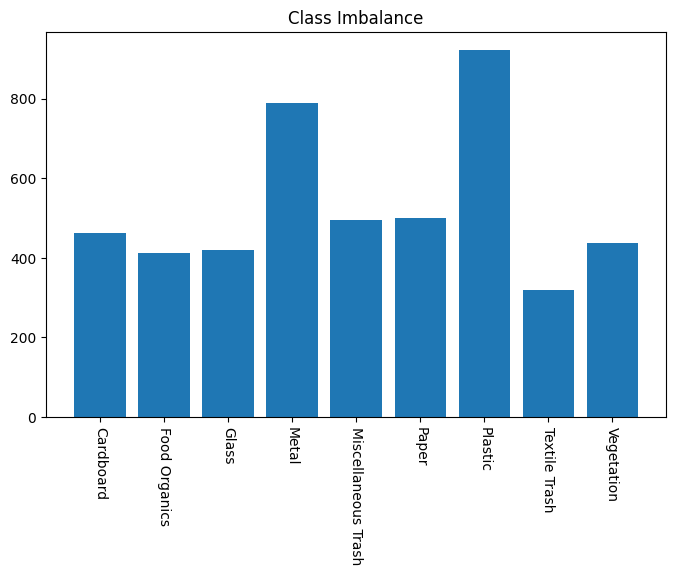

In [3]:
# Construct the path to the 'RealWaste' directory
notebook_path = os.path.abspath('01-cnn-waste-classification-wrangling-EDA.ipynb')
project_root = os.path.dirname(os.path.dirname(notebook_path))
base_dir = os.path.join(project_root, 'data', 'RealWaste')

subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
subdirs.sort()   


# Create a dictionary of labels and a list of file counts
labels = []
num_files = []
for subdir in subdirs:
    path = os.path.join(base_dir, subdir)
    num_files.append(len(os.listdir(path)))
    labels.append(subdir)

# Create the category_labels dictionary as requested
category_labels = dict(zip(labels, range(len(labels))))

print(f"Discovered categories: {labels}")
print(f"Category label map: {category_labels}")

# Assess class imbalance
fig = plt.figure(figsize=(8, 5))
plt.bar(labels, num_files)
plt.xticks(rotation=270)
plt.title("Class Imbalance")
plt.show()

# Example of how you would now get a path to a specific category
# cardboard_path = os.path.join(base_dir, 'Cardboard')
# print(f"Path to Cardboard: {cardboard_path}")

So these categories are less than perfectly balanced - but nothing is _particularly_ underrepresented.  Also there's a "Miscellaneous Trash" category, which I don't really like.  Note that most of the class imbalance consists of just "Plastic" and "Metal", which is interesting.  Let's sample some images.

In [4]:
def rand_imgs_folder(folder: str, num_imgs: int = 8, max_cols: int = 4, figsize: tuple = (12, 8)):
    """
    Randomly selects and displays a sample of images from a specified folder.
    """
    # Assuming 'base_dir' is a global variable defined in the notebook's setup
    #global base_dir
    
    # Build the full, cross-platform path to the image directory
    source_path = os.path.join(base_dir, folder)
    
    # Load and randomly select filenames
    filenames = os.listdir(source_path)
    if not filenames:
        print(f"No images found in {source_path}")
        return
        
    sampled_filenames = np.random.choice(filenames, min(num_imgs, len(filenames)), replace=False)
    
    # Establish rows and columns for the plot grid
    cols = min(len(sampled_filenames), max_cols)
    rows = int(np.ceil(len(sampled_filenames) / cols))
    
    # Organize and draw the figure
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    fig.suptitle(f"Sample Images from: {folder}", fontsize=16)
    
    for i, filename in enumerate(sampled_filenames):
        img_path = os.path.join(source_path, filename)
        image = mpimg.imread(img_path)
        
        ax = axes[i]
        ax.imshow(image)
        ax.set_title(filename)
        ax.axis('off')
        
    # Hide any unused subplots
    for j in range(len(sampled_filenames), len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


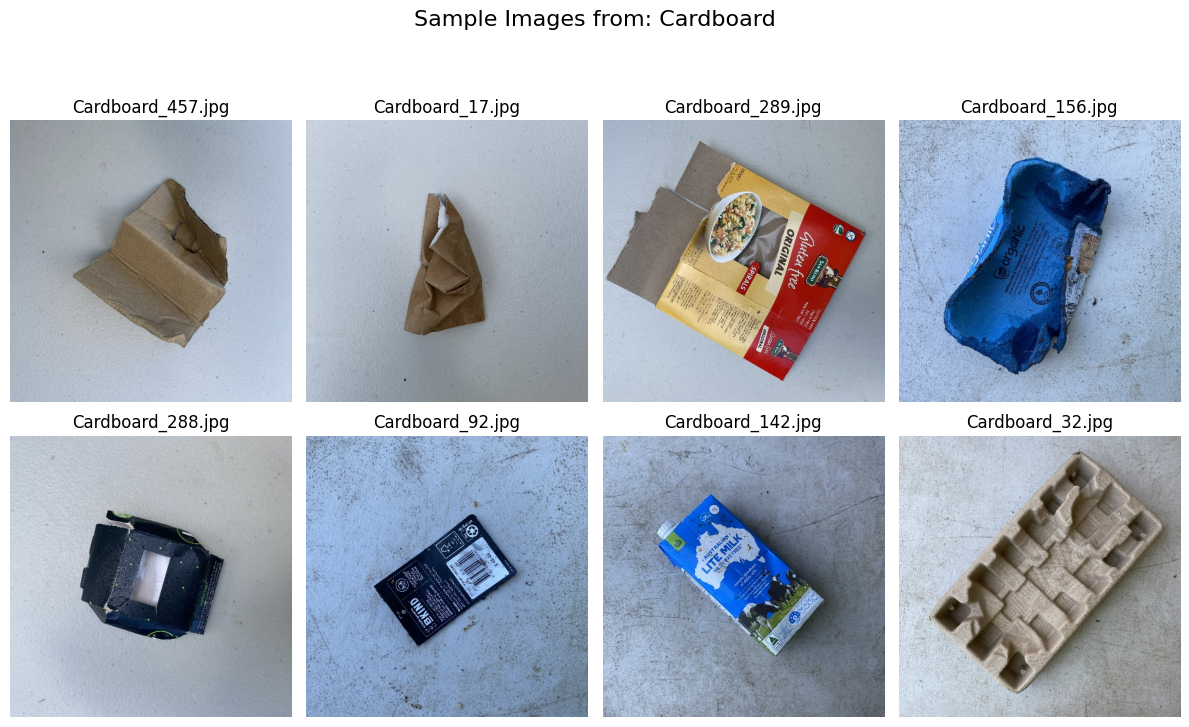

In [5]:
rand_imgs_folder("Cardboard")



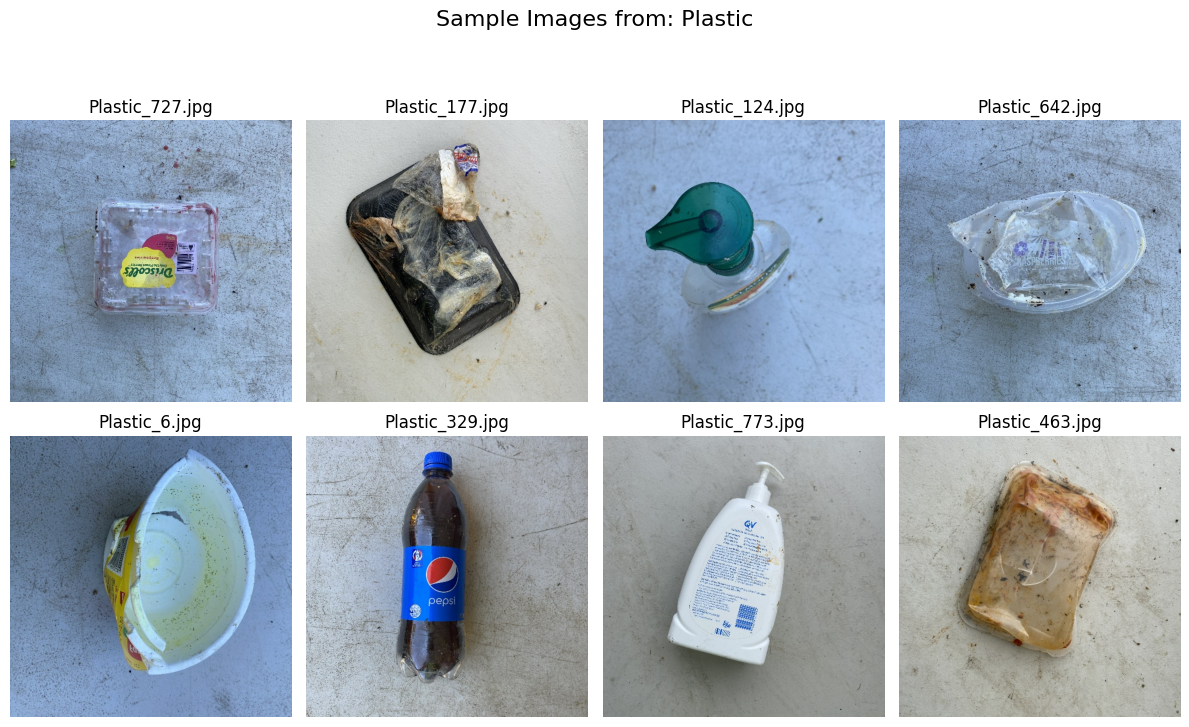

In [6]:
rand_imgs_folder("Plastic")

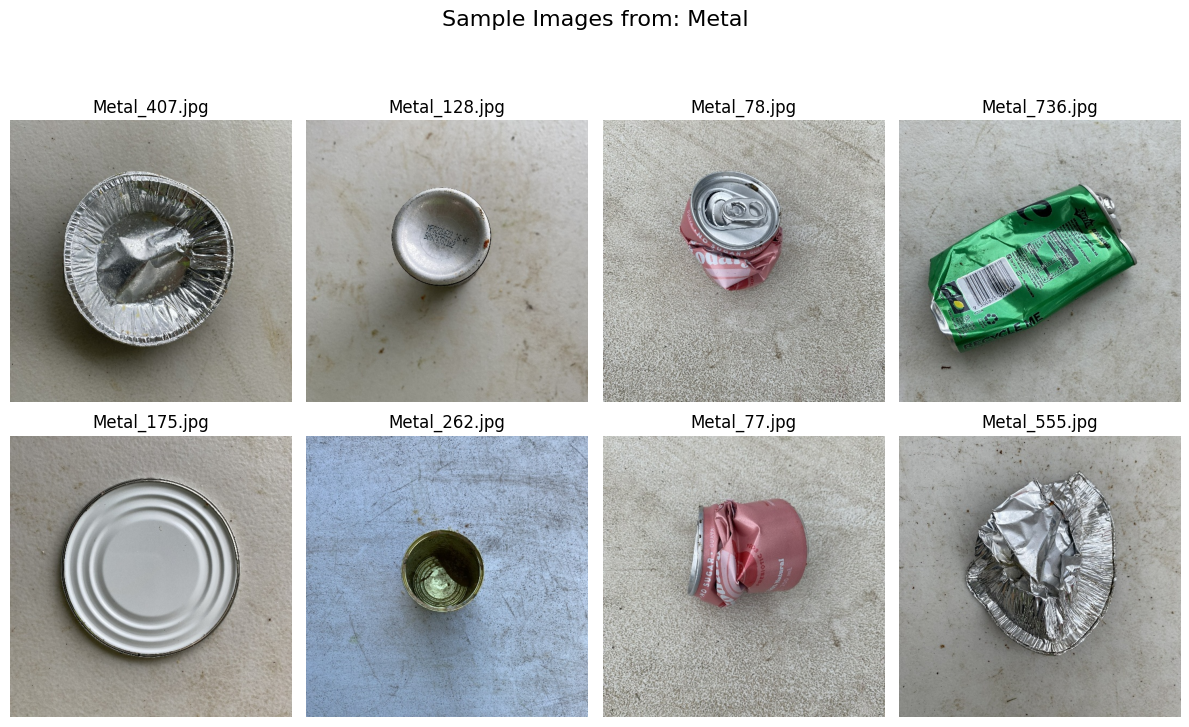

In [7]:
rand_imgs_folder("Metal")

And let's examine the _really_ problematic category...

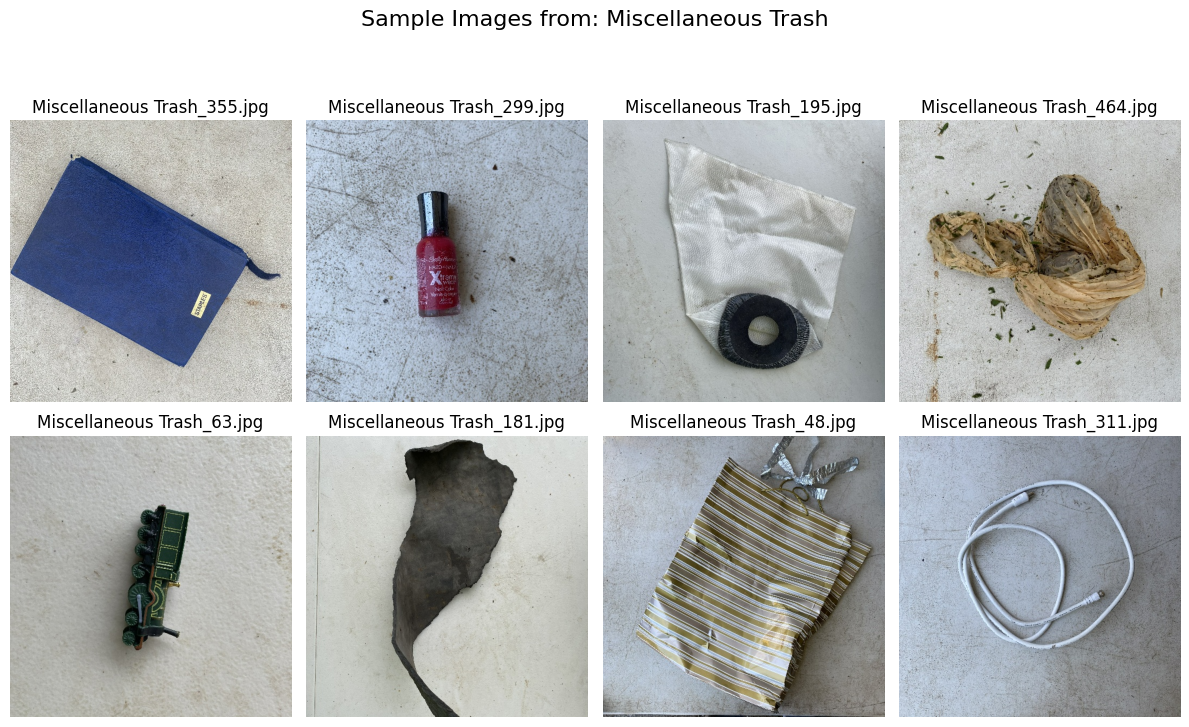

In [8]:
rand_imgs_folder("Miscellaneous Trash")

Perhaps this is naive of me, but "miscellaneous" seems to be a problematic concept in any scheme of categorization; it also looks to me like some of these definitely consist of metals, plastics, textiles, etc.  This is going to be a foundational limitation throughout the study.

Let's verify that the images are all consistently sized.

In [9]:
def check_image_sizes(source):
    sizes = []
    for filename in os.listdir(source):
        image_path = os.path.join(source, filename)
        image = PIL.Image.open(image_path)
        size = [image.width, image.height]
        sizes.append(size)
    return sizes

def check_list_identical(list_of_elements):
    return all(element == list_of_elements[0] for element in list_of_elements)

# Main loop to run the checks
for subdir in subdirs:
    folder_path = os.path.join(base_dir, subdir)
    sizes = check_image_sizes(folder_path)
    print(f"Folder: {subdir}, First Element Size: {sizes[0]}, All Identical: {check_list_identical(sizes)}")

Folder: Cardboard, First Element Size: [524, 524], All Identical: True
Folder: Food Organics, First Element Size: [524, 524], All Identical: True
Folder: Glass, First Element Size: [524, 524], All Identical: True
Folder: Metal, First Element Size: [524, 524], All Identical: True
Folder: Miscellaneous Trash, First Element Size: [524, 524], All Identical: True
Folder: Paper, First Element Size: [524, 524], All Identical: True
Folder: Plastic, First Element Size: [524, 524], All Identical: True
Folder: Textile Trash, First Element Size: [524, 524], All Identical: True
Folder: Vegetation, First Element Size: [524, 524], All Identical: True


In [10]:
# original images are 524 x 524... rescaling to 131 x 131 will reduce size to 1/16, reducing fitting time

X = []
y = []

for subdir, label in category_labels.items():
    path = os.path.join(base_dir, subdir)
    img_files = os.listdir(path)
    for file in img_files:
        image_path = os.path.join(path, file)
        X.append(PIL.Image.open(image_path).resize((131, 131), PIL.Image.Resampling.LANCZOS))
        y.append(label)


3


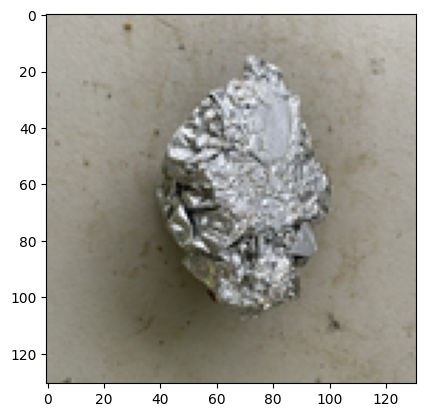

In [11]:

plt.imshow(X[1969])
print(y[1969])

In [12]:
def rand_imgs_list(cat, cat_labels=category_labels, X=X, y=y, num_imgs=4, max_cols=4, figsize=(12,8)):
    # establish index range for images, select at random
    img_ind = np.random.choice(range(y.index(cat), y.index(cat)+y.count(cat)), num_imgs, replace=False)
    imgs = []
    for img in img_ind:
        imgs.append(X[img])
    
    # get label for source
    source = [i for i in category_labels if category_labels[i] == cat]
    
    # establish rows and columns    
    if num_imgs <= max_cols:
        cols = num_imgs
        rows = 1
    elif num_imgs > max_cols:
        cols = max_cols
        rows = int(np.ceil(num_imgs / max_cols))
    
    if num_imgs > 16:
        figsize=(20,14)
    elif num_imgs > 8:
        figsize=(16,11)
    
    # organize and draw the figure
    f = plt.figure(figsize=figsize)
    
    plt.title(f"Sample images from {source}")
    img_index = 0                                    # I hate this, but it works and I can't be bothered right now
    for img in imgs:
        img_index +=1
        f.add_subplot(rows, cols, img_index)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

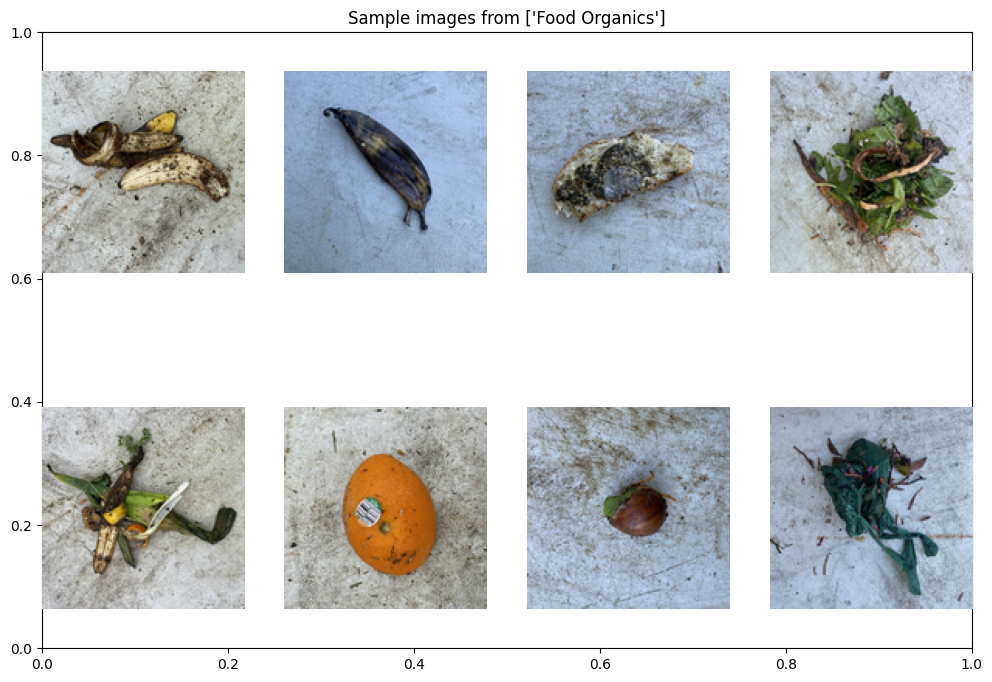

In [13]:
rand_imgs_list(1, num_imgs=8)

## Image transformation and augmentation

As I'm new to image augmentation, I'd like to begin by - for each image - choosing an augmentation transform at random, applying it, and adding it to the image set.  A first step (at least for now) is to convert to grayscale for faster computation and, perhaps, better accuracy.

In [14]:
# rgb to grayscale
# undoing this, in order to apply InceptionV3 etc which require RGB images for now
#X = tf.image.rgb_to_grayscale(np.asarray(X))

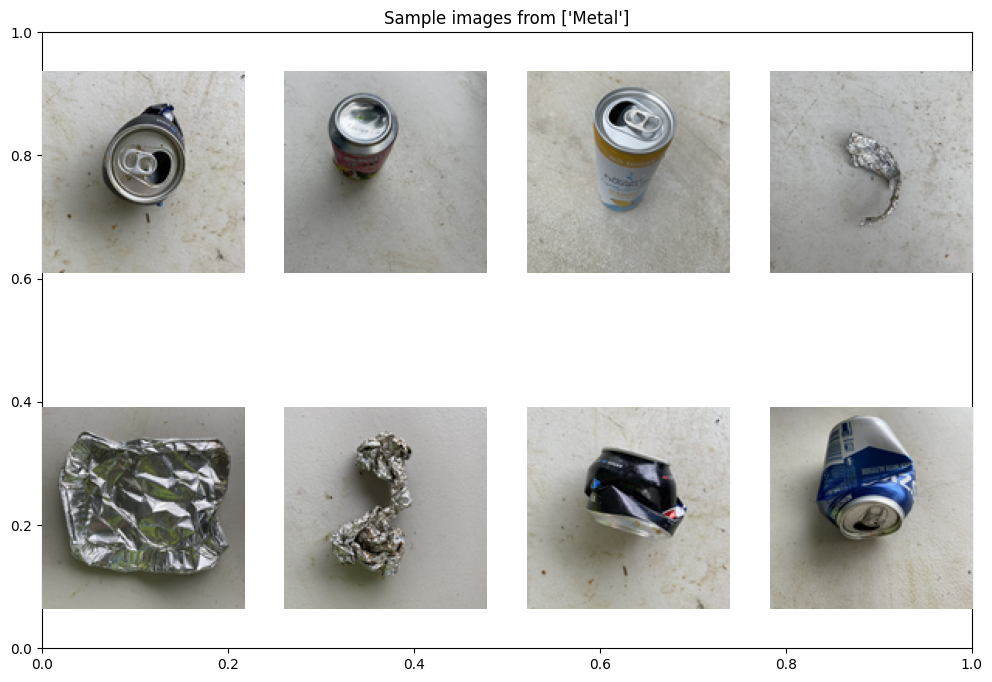

In [15]:
rand_imgs_list(3, X=X, num_imgs=8)

This is extremely odd.  I can't find any examples online of this happening with tf.image.rgb_to_grayscale - these are transformed, but most certainly not monochromatic images!  This shouldn't be a difficult step at all, but before I try other methods, let's see if it's something simple.

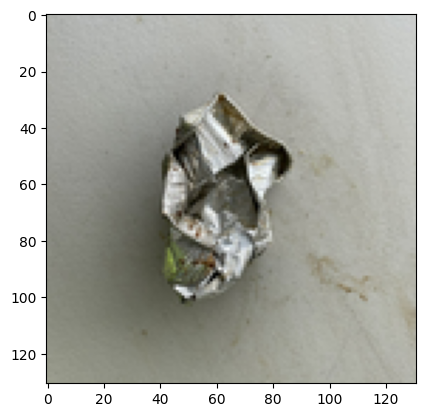

In [16]:
plt.imshow(X[1743], cmap='gray')

So this is a color mapping issue - fine. Let's move on.

In [17]:
# defining some layers for augmentation; these can be moved inside the model, which would be more useful for production


tf_rescale = tf.keras.Sequential([layers.Rescaling(1./255)])


''' note:  This tf_contrast will return values in the full [0, 255] range according to tf docs must be applied prior 
    to rescaling.  Since I intend (initially at least) to apply augmentations at random, this means that rescaling needs 
    to be the last step in the augment_random function; also, I must apply rescaling to the original images as well. '''

tf_contrast = tf.keras.Sequential([layers.RandomContrast(0.2)])

tf_zoom = tf.keras.Sequential([layers.RandomZoom(0.2)])


'''I overpondered this one.  Ultimately I decided to create separate horizontal and vertical flip layers, because
   this will produce more flips in the augmentation set, and considering the nature of the problem - visual identification
   of items found in garbage - one would expect many effective 'flips' in practice.'''

#tf_h_flip = tf.keras.Sequential([layers.RandomFlip(mode="horizontal")])
#tf_v_flip = tf.keras.Sequential([layers.RandomFlip(mode="vertical")])

# the above seem to be... not working
tf_flip = tf.keras.Sequential([layers.RandomFlip()])


tf_translate = tf.keras.Sequential([layers.RandomTranslation(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2))])

# I see no reason why rotation shouldn't be pi radians in either direction?
tf_rotate = tf.keras.Sequential([layers.RandomRotation(factor=(-0.5,0.5))])

# decided not to use tf_crop as it takes fixed height and width parameters
# may come back to this
#tf_crop = tf.keras.Sequential([layers.RandomCrop(height=, width=)])


2025-08-12 14:01:16.756472: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-08-12 14:01:16.756494: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: d3aa4c2ed728
2025-08-12 14:01:16.756500: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: d3aa4c2ed728
2025-08-12 14:01:16.756577: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 575.64.3
2025-08-12 14:01:16.756591: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 575.64.3
2025-08-12 14:01:16.756602: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 575.64.3


Let's test this before moving on.

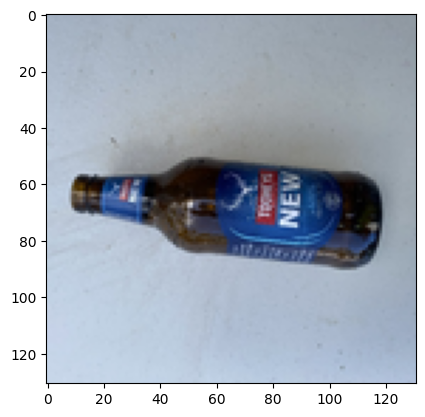

In [18]:
plt.imshow(X[1283])

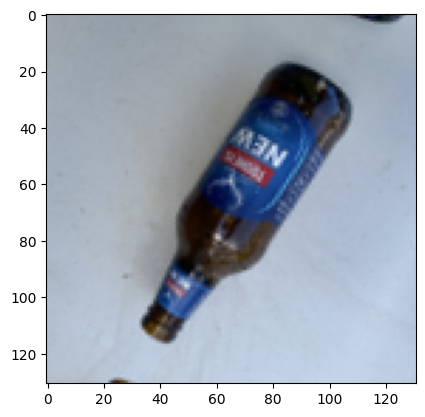

In [19]:
# try rescale on the augmentation
ZZ = tf_rescale(tf_rotate(X[1283]))
plt.imshow(ZZ)

In [20]:
'''building a function to apply a fixed number of random (without repeat) augmentations
note well, of course: the augmentations must be applied ONLY to training set
however, rescale needs to be applied to all data, must remember to do this later'''

augmentation_list=["contrast", "zoom", "flip", "translate", "rotate"]

def augment_random(image_n, X=X, y=y, num_augs=1, aug_list=augmentation_list):
    augmentations=[]
    aug_labels=[]
    n_as_str = str(image_n)
    augs = np.random.choice(len(aug_list), num_augs, replace=False)
    for aug in augs:
        aug_choice = augmentation_list[aug]
        
        # this seems absolutely disgracefully unpythonic, and I should return to make it classier
        # additionally, current venv can't do this on GPU.. diagnose and fix when you find the time
        if aug_choice == "contrast":
            with tf.device('/cpu:0'):
                aug_img = tf_contrast(X[image_n])
        elif aug_choice == "zoom":
            aug_img = tf_zoom(X[image_n])
        elif aug_choice == "flip":
            aug_img = tf_flip(X[image_n])
        elif aug_choice == "translate":
            aug_img = tf_translate(X[image_n])
        elif aug_choice == "rotate":
            aug_img = tf_rotate(X[image_n])
        
        # no matter what, need to apply tf_rescale()
        aug_img = tf_rescale(aug_img)
        
        # append both X and Y for augmentation
        augmentations.append(aug_img)
        aug_labels.append(y[image_n])
        
    return augmentations, aug_labels

In [21]:
test1, test2 = augment_random(1023, X=X, y=y, num_augs=4)

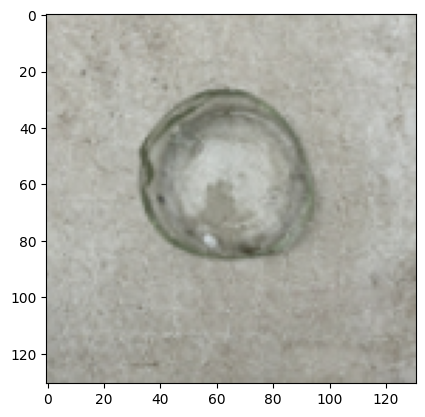

In [22]:
plt.imshow(test1[2])

On the face of it, this seems to work.

In [23]:
# train-test split

X = np.array(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [24]:
def augment_images_list(X, y, num_augs=1):
    # I don't like this, but alternatives seem to me to risk mismatching X and y
    aug_X = []
    aug_y = []
    for i in range(len(X)):
        aug_imgs, aug_labels = augment_random(i, X=X, y=y, num_augs=num_augs)
        for img in aug_imgs:
            aug_X.append(img)
        for label in aug_labels:
            aug_y.append(label)
        # include the original image and label of course
        aug_X.append(X[i])
        aug_y.append(y[i])
    return aug_X, aug_y

In [25]:
# ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

# having some RAM issues, hopefully this fixes it
tf.keras.backend.clear_session()


# augment the training sets
# reducing number of augmentations to ONE per original image to reduce GPU memory challenges
X_train_aug, y_train_aug = augment_images_list(X_train, y_train, num_augs=1)

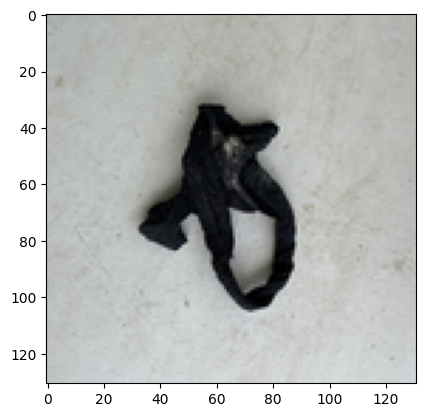

In [26]:
plt.imshow(X_train_aug[902])


This appears to be working as intended!  I'm going to save the now augmented training sets (as well as the test set) and start building models in a new notebook, However, we're now at... around 15,000 images.  _For the training set._  I'd much rather not create that many .jpg files, and various sources suggest that pickle is a good, practical method.

In [27]:
X_test_rescale = tf_rescale(X_test)

In [28]:
import pickle


notebook_path = os.path.abspath('01-cnn-waste-classification-wrangling-EDA.ipynb')
project_root = os.path.dirname(os.path.dirname(notebook_path))

# pickle files go into the data directory
save_dir = os.path.join(project_root, 'data')
os.makedirs(save_dir, exist_ok=True)

# Save the files with the correct path
with open(os.path.join(save_dir, 'RealWaste_X_train_aug_RGB.pkl'), 'wb') as fh:
    pickle.dump(X_train_aug, fh)

with open(os.path.join(save_dir, 'RealWaste_X_test_RGB.pkl'), 'wb') as fh:
    pickle.dump(X_test, fh)

with open(os.path.join(save_dir, 'RealWaste_y_train_aug_RGB.pkl'), 'wb') as fh:
    pickle.dump(y_train_aug, fh)

with open(os.path.join(save_dir, 'RealWaste_y_test_RGB.pkl'), 'wb') as fh:
    pickle.dump(y_test, fh)

In [29]:
# now go back and do it for monochrome
# X = tf.image.rgb_to_grayscale(np.asarray(X)) - this worked on CPU, now there are CUDA problems
# this is a lot more trouble than I expected

def gs_img(img):
    img = tf.image.rgb_to_grayscale(img)
    return img

# perhaps I should just do this with the CPU instead?
tf.keras.backend.clear_session()

X_test_mono = [gs_img(img) for img in X_test]

# and again
tf.keras.backend.clear_session()

X_train_aug_mono = [gs_img(img) for img in X_train_aug]

In [30]:
with open(os.path.join(save_dir, 'RealWaste_X_train_aug.pkl'), 'wb') as fh:
    pickle.dump(X_train_aug_mono, fh)

with open(os.path.join(save_dir, 'RealWaste_X_test.pkl'), 'wb') as fh:
    pickle.dump(X_test_mono, fh)

with open(os.path.join(save_dir, 'RealWaste_y_train_aug.pkl'), 'wb') as fh:
    pickle.dump(y_train_aug, fh)

with open(os.path.join(save_dir, 'RealWaste_y_test.pkl'), 'wb') as fh:
    pickle.dump(y_test, fh)

That should suffice.  In the next notebook, I'm going to train some CNN's on these.